# MS-CELEB Face Recognition

## Importing the libraries


In [13]:
# from google.colab import files
# files.upload()

# ! mkdir -p ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets download -d danupnelson/14-celebrity-faces-dataset
# ! mkdir -p data
# ! unzip 14-celebrity-faces-dataset.zip -d ./data/

14-celebrity-faces-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  14-celebrity-faces-dataset.zip
  inflating: ./data/14-celebrity-faces-dataset/data/train/anne_hathaway/316px-Anne_Hathaway_@_2018.09.15_Human_Rights_Campaign_National_Dinner,_Washington,_DC_USA_06194_(43805104245)_(cropped).jpg  
  inflating: ./data/14-celebrity-faces-dataset/data/train/anne_hathaway/353px-Anne_Hathaway_2019_(cropped).jpg  
  inflating: ./data/14-celebrity-faces-dataset/data/train/anne_hathaway/393px-Denzel_Washington_og_Anne_Hathaway_IMG_6550b_Harry_Wad.jpg  
  inflating: ./data/14-celebrity-faces-dataset/data/train/anne_hathaway/398px-Anne_Hathaway_in_2017.png  
  inflating: ./data/14-celebrity-faces-dataset/data/train/anne_hathaway/417px-Anne_Hathaway_in_2016.jpg  
  inflating: ./data/14-celebrity-faces-dataset/data/train/anne_hathaway/428px-Anne_Hathaway_TIFF_2008.jpg  
  inflating: ./data/14-celebrity-faces-dataset/data/train/anne_hathaway/44

In [4]:
# ! pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.1 MB/s eta 0:00:00


In [24]:
import os
import shutil
import pathlib
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers
from PIL import Image
from mtcnn.mtcnn import MTCNN

# to make this notebook's output stable across runs
np.random.seed(42)

# Constants
SIZE_OF_IMAGES = (256, 256)
# SIZE_OF_IMAGES = (512, 512)
SIZE_OF_BATCH = 8
DATA_DIR = pathlib.Path('./data/14-celebrity-faces-dataset/data/')
MODELS_DIR = pathlib.Path('./models')

print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Downloading the data

## Functions

In [2]:

def plot_history(history):
    """"Plot the accuracy, loss, precision, recall and AUC \
        curves for training and validation."""

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    auc = history.history["auc"]
    val_auc = history.history["val_auc"]

    precision = history.history["precision"]
    val_precision = history.history["val_precision"]

    recall = history.history["recall"]
    val_recall = history.history["val_recall"]

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(321)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(322)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid()

    plt.subplot(323)
    plt.plot(epochs, precision, "bo", label="Training precision")
    plt.plot(epochs, val_precision, "b", label="Validation precision")
    plt.title("Training and validation precision")
    plt.legend()
    plt.grid()

    plt.subplot(324)
    plt.plot(epochs, recall, "bo", label="Training recall")
    plt.plot(epochs, val_recall, "b", label="Validation recall")
    plt.title("Training and validation recall")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, (5, 6))
    plt.plot(epochs, auc, "bo", label="Training AUC")
    plt.plot(epochs, val_auc, "b", label="Validation AUC")
    plt.title("Training and validation AUC")
    plt.legend()
    plt.grid()

    plt.show()

def show_eval_results(test_model, test_dataset, labels=None):
    """Evaluate the model on the test dataset and print the results."""

    eval_results = test_model.evaluate(test_dataset, labels)

    print(f"Test loss: {eval_results[0]:.3f}")
    print(f"Test accuracy: {eval_results[1]:.3f}")
    print(f"Test AUC: {eval_results[2]:.3f}")
    print(f"Test Precision: {eval_results[3]:.3f}")
    print(f"Test Recall: {eval_results[4]:.3f}")


detector = MTCNN()


def extract_face(filename, required_size=SIZE_OF_IMAGES):
    # # load image from file
    pixels = plt.imread(filename)

    if pixels.ndim == 2:
        pixels = np.stack((pixels,)*3, axis=-1)

    if pixels.shape[2] == 1:
        pixels = np.concatenate((pixels,)*3, axis=0)

    if pixels.shape[2] > 3:
        pixels = pixels[:, :, :3]
    # create the detector, using default weights
    # detect faces in the image
    results = detector.detect_faces(pixels)
    if len(results) == 0:
        return None
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array


2023-01-18 17:27:20.331129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 17:27:20.333794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-18 17:27:20.334205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-18 17:27:20.334486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may h

## Face detection

In [14]:
for folder in os.listdir(DATA_DIR / 'train'):
    for file in os.listdir(DATA_DIR / 'train' / folder):
        pixels = extract_face(DATA_DIR / 'train' / folder / file)
        if pixels is None:
            continue
        os.makedirs(DATA_DIR / 'train_cropped' / folder, exist_ok=True)
        plt.imsave(DATA_DIR / 'train_cropped' / folder / file, pixels)

1/1 [==============================] - 0s 14ms/step


In [15]:
for folder in os.listdir(DATA_DIR / 'val'):
    for file in os.listdir(DATA_DIR / 'val' / folder):
        pixels = extract_face(DATA_DIR / 'val' / folder / file)
        os.makedirs(DATA_DIR / 'val_cropped' / folder, exist_ok=True)
        plt.imsave(DATA_DIR / 'val_cropped' / folder / file, pixels)

1/1 [==============================] - 0s 15ms/step


## Importing the data

In [3]:

train_dataset = image_dataset_from_directory(DATA_DIR / "train_cropped",
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DATA_DIR / "val_cropped",
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             seed=42)


Found 212 files belonging to 14 classes.
Found 70 files belonging to 14 classes.


In [4]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (16, 256, 256, 3)
labels batch shape: (16, 14)


## Data augmentation

In [5]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(SIZE_OF_IMAGES[0], SIZE_OF_IMAGES[1]),
    layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ]
)

AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, resize=False, shuffle=False, augment=False, batch=False):
    # Resize and rescale all datasets.
    if resize:
        ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                    num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    if batch:
        ds = ds.batch(SIZE_OF_BATCH)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


In [6]:
train_dataset = prepare(train_dataset, shuffle=True, augment=True, resize=True)
validation_dataset = prepare(validation_dataset, resize=True)

In [7]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (16, 256, 256, 3)
labels batch shape: (16, 14)


## Implementing Modern DNN Architecture using Residual CNN

In [19]:
def conv_layer_with_batch_norm(x, filter_size, kernel_size=3):

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters=filter_size,
                               kernel_size=kernel_size,
                               use_bias=False,
                               padding='same')(x)
    return x


inputs = keras.Input(shape=SIZE_OF_IMAGES + (3,))

x = layers.Conv2D(filters=32, kernel_size=5,
                  use_bias=False, padding='same')(inputs)

x = conv_layer_with_batch_norm(x, 32, kernel_size=5)

residual = x
x = conv_layer_with_batch_norm(x, 32, kernel_size=5)
x = conv_layer_with_batch_norm(x, 32, kernel_size=3)
x = conv_layer_with_batch_norm(x, 32, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(32, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

x = conv_layer_with_batch_norm(x, 64, kernel_size=3)


residual = x
x = conv_layer_with_batch_norm(x, 64, kernel_size=3)
x = conv_layer_with_batch_norm(x, 64, kernel_size=3)
x = conv_layer_with_batch_norm(x, 64, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(64, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(x, 64, kernel_size=3)
x = conv_layer_with_batch_norm(x, 128, kernel_size=3)
x = conv_layer_with_batch_norm(x, 128, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(128, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(x, 128, kernel_size=3)
x = conv_layer_with_batch_norm(x, 128, kernel_size=3)
x = conv_layer_with_batch_norm(x, 128, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(128, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(x, 256, kernel_size=3)
x = conv_layer_with_batch_norm(x, 256, kernel_size=3)
x = conv_layer_with_batch_norm(x, 256, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(256, 1, strides=(2, 2), use_bias=False)(residual)
x = layers.Add()([residual, x])

x = layers.Dropout(0.1)(x)

residual = x
x = conv_layer_with_batch_norm(x, 256, kernel_size=3)
x = conv_layer_with_batch_norm(x, 512, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(512, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

x = layers.Dropout(0.3)(x)


residual = x
x = conv_layer_with_batch_norm(x, 512, kernel_size=3)
x = conv_layer_with_batch_norm(x, 512, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(512, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])


x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(14, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)


print(model.summary())


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_91 (Conv2D)             (None, 256, 256, 32  2400        ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_266 (Batch  (None, 256, 256, 32  128        ['conv2d_91[0][0]']              
 Normalization)                 )                                                          

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'modern_arch_ERS_174718012023.keras'),
                                    save_best_only=True,
                                    monitor="val_loss")
]
history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=validation_dataset,
                    callbacks=callbacks)


Epoch 1/200


2023-01-18 21:27:09.921594: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.00MiB (rounded to 8388608)requested by op model_12/batch_normalization_282/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-01-18 21:27:09.921664: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-01-18 21:27:09.921672: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 493, Chunks in use: 490. 123.2KiB allocated for chunks. 122.5KiB in use in bin. 41.1KiB client-requested in use in bin.
2023-01-18 21:27:09.921675: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 115, Chunks in use: 113. 60.0KiB allocated for chunks. 59.0KiB in use in bin. 56.5KiB client-requested

ResourceExhaustedError: Graph execution error:

Detected at node 'model_12/batch_normalization_282/FusedBatchNormV3' defined at (most recent call last):
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2491/589385177.py", line 11, in <module>
      history = model.fit(train_dataset,
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 571, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_12/batch_normalization_282/FusedBatchNormV3'
Detected at node 'model_12/batch_normalization_282/FusedBatchNormV3' defined at (most recent call last):
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2491/589385177.py", line 11, in <module>
      history = model.fit(train_dataset,
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/erfan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 571, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_12/batch_normalization_282/FusedBatchNormV3'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[16,128,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_12/batch_normalization_282/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[assert_less_equal_2/Assert/AssertGuard/pivot_f/_53/_119]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[16,128,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_12/batch_normalization_282/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_61062]

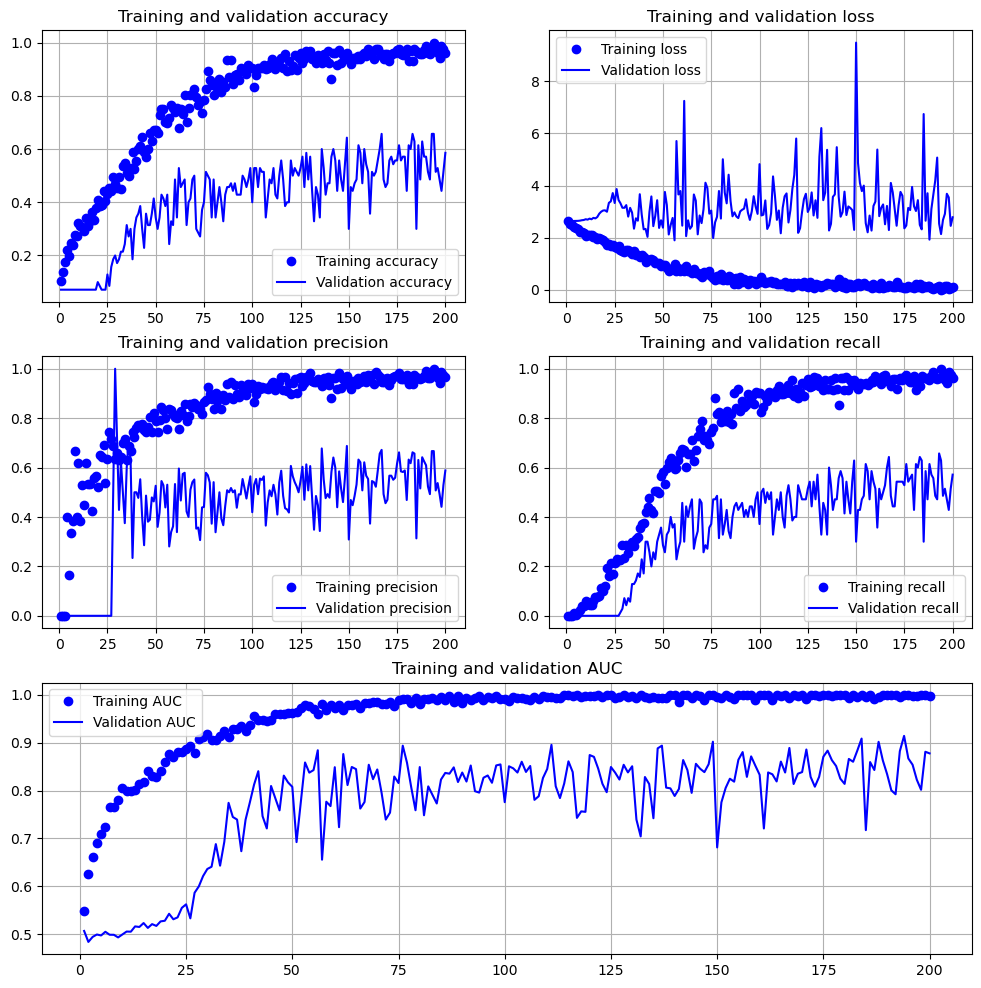

In [10]:
plot_history(history)


In [11]:

test_model = keras.models.load_model(
    os.path.join(MODELS_DIR, 'modern_arch_ERS_042918012023.keras'))
show_eval_results(test_model, validation_dataset)

5/5 [==============================] - 1s 30ms/step - loss: 1.9016 - accuracy: 0.4286 - auc: 0.8843 - precision: 0.5306 - recall: 0.3714
Test loss: 1.902
Test accuracy: 0.429
Test AUC: 0.884
Test Precision: 0.531
Test Recall: 0.371
